# Covid Data Trends and Statistics
#### By: Jacob Siegel

## Abstract 

There is a wide rage in the death rate attributed to the Corona Virus between the US states in the time frame from the onset of the Pandemic to August 2021. The range is from 0.038 % of the population in Hawaii to 0.3% of the population in New York, nearly an order of magnitude difference. To understand this range in outcomes, a state-level dataset was assemble with various attributes pertaining to each state such as average obesity, average GDP, education level, race, population density, political party of the governor, etc. This dataset was then used as the input for sklearn’s linear regression model RidgeCV, a ridge regression with build in cross-validation. This analysis shows that many factors contributed to this range in death rate with the most salient features being the population density, obesity rate, and education level of the state. The political party of the state’s leadership (Governor as of 2020) does not appear to have a strong influence on the death rate, however, news and social media have fomented an intense belief that one political party is better at managing the corona virus than another, creating a strong divide and leaving both sides attributing failure to the other. 


In [194]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

#Import sklearn features
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

#Import Statsmodel features
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
!pip install plotly==5.3.1
import plotly.express as px 

#Stop Warmings
import warnings
warnings.filterwarnings("ignore")

## 1.0 Data Overview

The data is a state-level overview of statistics obtained from a variety of sources including the CDC, Bureau of Labor Statistics, KFF and Wikipedia. The columns and source are as follows:

<u> Columns: </u>
* State: Name of State
* Population: Population of state 
* Political Party: Governor of State during 2020 
* Election: 2016 Presidential Election Results
* Cases: Total cases recorded for state as of August 1, 2021
* Deaths: Total deaths recorded for state as of August 1, 2021
* Tests: Total tests recorded for state as of August 1, 2021
* Vaccine: Total vaccines recorded for state as of August 1, 2021
* Unemployment: Average unemployment rate for state
* GDP: Average GDP per capita per state (US$)
* Area: Area of State (miles^2)
* White/Black/Hispanic/Asia: Percentage of each race in the state
* High_Shool/College: Percentage of state with a high school or college degree
* Obesity: percentage of state considered Obese
* Life Expectancy: Average life expectancy of the state
* Med_Age: Median age per state

<u> Sources: </u>
* https://www.worldometers.info/coronavirus/country/us/
* https://en.wikipedia.org/wiki/List_of_current_United_States_governors
* https://worldpopulationreview.com/state-rankings/educational-attainment-by-state
* https://www.bls.gov/web/laus/laumstrk.htm
* https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP_per_capita
* https://www.cdc.gov/obesity/data/prevalence-maps.html
* https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D


In [195]:
#Load data set
States = pd.read_csv("States.csv")
States.sample(2)

State  Population Political_Party    Election    Cases  Deaths  \
17  Louisiana     4648794      Democratic  Republican   573903   11210   
8     Florida    21477737      Republican  Republican  2770817   39695   

       Tests   Vaccine  Unemployment    GDP      Area  White  Black  Hispanic  \
17   8499174   3783465           6.9  43917  52378.13  0.588  0.319     0.052   
8   33718946  23116303           5.0  39543  65757.70  0.530  0.150     0.266   

    Asian  High_School  College  Obesity  Life_Expectancy  Med_Age  
17  0.017         0.85     0.24     35.9             76.1     37.5  
8   0.027         0.88     0.30     27.0             80.2     42.5

A second data set of deaths recorded in 1 week during August to highligh recent changes and more vacinations. 

In [196]:
#Appendix data for deatrhs in the past 7 days per state
States7 = pd.read_csv("Last_7_Days.csv")
States7.sample(2)

State  Deaths_7_Days
14     Iowa             39
9   Georgia            470

In [197]:
States.describe().round(1).T

count        mean         std       min        25%  \
Population        50.0   6551895.9   7389342.9  578759.0  1827712.2   
Cases             50.0    712852.0    811884.1   25320.0   206516.5   
Deaths            50.0     12285.9     14422.9     260.0     2556.2   
Tests             50.0  10702610.2  14409660.6  456246.0  2878415.5   
Vaccine           50.0   6884604.4   8229252.3  452145.0  1790883.0   
Unemployment      50.0         5.2         1.6       2.5        4.0   
GDP               50.0     48399.1      8764.9   31881.0    43279.5   
Area              50.0     75933.5     97327.4    1544.9    37416.6   
White             50.0         0.7         0.2       0.2        0.6   
Black             50.0         0.1         0.1       0.0        0.0   
Hispanic          50.0         0.1         0.1       0.0        0.1   
Asian             50.0         0.0         0.1       0.0        0.0   
High_School       50.0         0.9         0.0       0.8        0.9   
College           50.0         0.3         0.1       0.2        0.3   
Obesity           50.0        32.1         3.9      23.8       29.3   
Life_Expectancy   50.0        78.8         1.8      74.8       77.9   
Med_Age           50.0        38.8         2.3      31.3       37.6   

                       50%         75%         max  
Population       4558233.5   7530849.0  39512223.0  
Cases             492664.0    880914.0   4046728.0  
Deaths              7576.0     13974.5     64786.0  
Tests            5585867.5  11435898.5  75404964.0  
Vaccine          4388322.5   9104884.5  45890960.0  
Unemployment           5.0         6.4         7.9  
GDP                47416.5     53772.2     65545.0  
Area               57093.2     84564.9    665384.0  
White                  0.7         0.8         0.9  
Black                  0.1         0.1         0.4  
Hispanic               0.1         0.1         0.5  
Asian                  0.0         0.0         0.4  
High_School            0.9         0.9         0.9  
College                0.3         0.3         0.4  
Obesity               32.1        34.8        40.8  
Life_Expectancy       79.1        79.9        82.3  
Med_Age               38.8        39.9        45.0

### 1.1 Feature Engineering

In [198]:
Case_Ave = States.Cases.sum() / States.Population.sum()   #Percentage of Cases for all US population
Death_Ave = States.Deaths.sum() / States.Population.sum() #Percentage of Deaths for all US Popilatiion
MorRate = States.Deaths.sum() / States.Cases.sum()        #mortality rate in the US
print('Percentage of cases for all US population:', round(Case_Ave*100, 2),'%')
print('The US mortality rate is:', round(MorRate*100, 2), '%')
print('Total deaths in the US is:', States.Deaths.sum())

Percentage of cases for all US population: 10.88 %
The US mortality rate is: 1.72 %
Total deaths in the US is: 614295


In [199]:
#Marker for state above or below national case average (to be used for logistics regression): 
States['Case_Compare'] = (States.Cases / States.Population > Case_Ave)*1 

#Marker for state above or below national death average (to be used for logistics regression):
States['Death_Compare'] = (States.Deaths / States.Population > Death_Ave)*1

#Positivity Rate of the tests (Toral Cases / Total Tests):
States['Percent_Tests'] = (States.Cases / States.Tests) *100

#Percentage of the state vacinated:
States['Percent_Vaccine'] = (States.Vaccine / States.Population) * 100

#Percentage of the state that has died (Total Deaths / Total Polulation):
States['Percent_Death'] = (States.Deaths / States.Population) * 100

#Percentage of the state that has died in the past 7 days (Total Deaths / Total Polulation):
States['Percent_Death_7'] = (States7.Deaths_7_Days / States.Population) * 100

#Percentage of the state that has died (Total Deaths / Total Polulation):
States['Percent_Cases'] = (States.Cases / States.Population) * 100

#Population Density of the state (Polpulation / Area):
States['Pop_Density'] = (States.Population / States.Area) 

#Marker for political party
States['Political_Party_N'] = States.Political_Party.apply(lambda x: '0' if x == 'Republican' else 1)
States['Political_Party_N'] = States['Political_Party_N'].astype('int64')

#Marker for Election
States['Election_N'] = States.Election.apply(lambda x: '0' if x == 'Republican' else 1)
States['Election_N'] = States['Election_N'].astype('int64')

Average death rate for all US population: 0.19 %
Minimum death rate from a state: 0.038
Maximum death rate from a state: 0.3
Standard deviation of death rate from all states: 0.063


<AxesSubplot:xlabel='Percent_Death'>

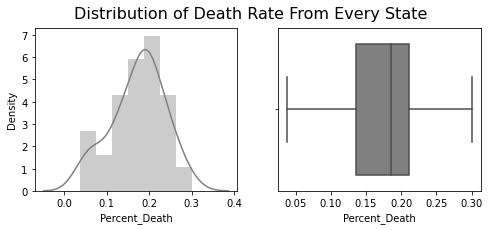

In [200]:
print('Average death rate for all US population:', round(Death_Ave*100, 2),'%')
print('Minimum death rate from a state:', round(States['Percent_Death'].min(),3))
print('Maximum death rate from a state:', round(States['Percent_Death'].max(),3))
print('Standard deviation of death rate from all states:', round(States['Percent_Death'].std(),3))

plt.figure(figsize=(8,3))
plt.suptitle('Distribution of Death Rate From Every State', fontsize=16)
plt.subplot(1,2,1)
sns.distplot(States['Percent_Death'], color="grey")
plt.subplot(1,2,2)
sns.boxplot(x='Percent_Death',data=States, color="grey")

## 2.0 EDA: Univariate Analysis With a Focus on Political Party

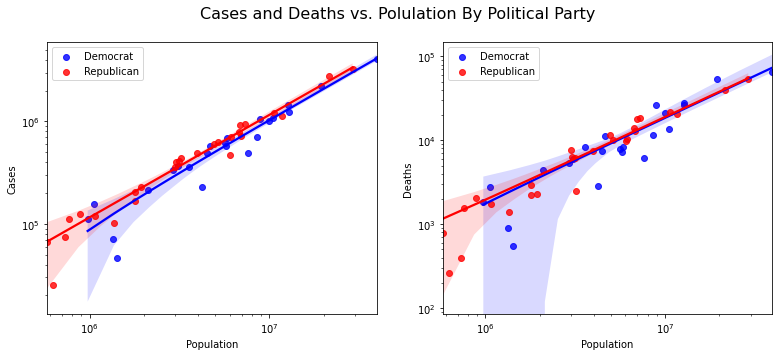

In [201]:
plt.figure(figsize=(13,5))
plt.suptitle('Cases and Deaths vs. Polulation By Political Party', fontsize=16)

j=1
for i in ['Cases', 'Deaths']:
    plt.subplot(1,2,j)
    sns.regplot(x="Population", y=i, data = States[States['Political_Party'] != 'Republican'], 
                color="b", label='Democrat')
    sns.regplot(x="Population", y=i, data = States[States['Political_Party'] != 'Democratic'], 
                color="r", label='Republican')
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()  
    j=j+1

Observation:
* The trend of state population vs Cases and Deaths in not surprising, and some scatter can be seen in the data. The trend for Deaths vs Population is nearly identical for both political parties, while the cases trend are slightly higher in Republic states. 

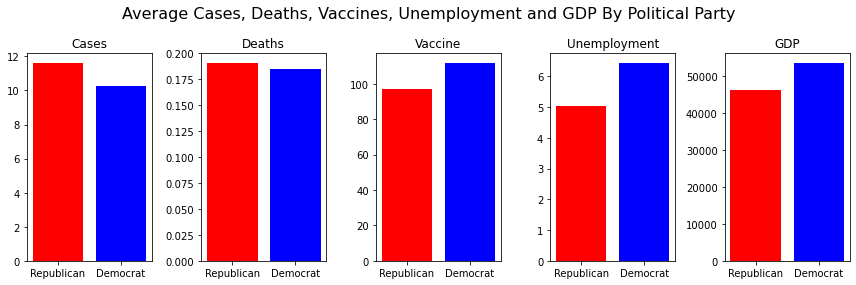

In [202]:
plt.figure(figsize=(12,4))
plt.suptitle('Average Cases, Deaths, Vaccines, Unemployment and GDP By Political Party', fontsize=16)
j=1
for i in ['Cases', 'Deaths', 'Vaccine']:
    plt.subplot(1,5,j)
    x = ['Republican', 'Democrat']
    y = np.array([(States[States['Political_Party'] != 'Democratic'][i].sum() / 
                   States[States['Political_Party'] != 'Democratic'].Population.sum()) * 100, 
                  (States[States['Political_Party'] != 'Republican'][i].sum() / 
                   States[States['Political_Party'] != 'Republican'].Population.sum()) * 100])
    plt.bar(x, y, color=['red', 'blue'])
    plt.tight_layout()
    plt.title(i)
    j=j+1

#------------------------------------------------------------------------------

for i in ['Unemployment', 'GDP']:
    x = ['Republican', 'Democrat']
    y = np.array([(np.array([States[States['Political_Party'] != 'Democratic'].Population * 
                             States[States['Political_Party'] != 'Democratic'][i]]).sum()) / 
                  States[States['Political_Party'] != 'Democratic'].Population.sum(),
                  (np.array([States[States['Political_Party'] != 'Republican'].Population * 
                             States[States['Political_Party'] != 'Republican'][i]]).sum()) / 
                  States[States['Political_Party'] != 'Republican'].Population.sum()])
    plt.subplot(1,5,j)
    plt.bar(x, y, color=['red', 'blue'])
    plt.tight_layout()
    plt.title(i)
    j=j+1

Observation:
* As seen from the previous trend, Republican states have a higher average number of cases while the average death rate for republican and democratic states is nearly the same. 
* Democratic states have a higher percentage of Vaccinations. The bar exceeds 100 percent as data is total number of shots for the states despite the fact that most people receive 2.  
* It is interesting to note that Republican states have lower average unemployment with democratic states have higher average GDP, thus both groups exceed in an important measure of the economy. 


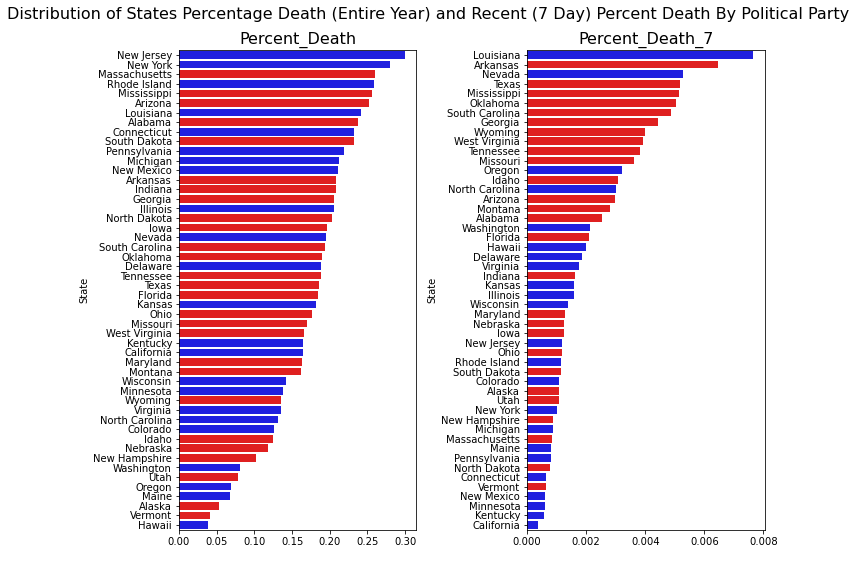

In [203]:
plt.figure(figsize = (10,8)) # To resize the plot
plt.suptitle('Distribution of States Percentage Death (Entire Year) and Recent (7 Day) Percent Death By Political Party', fontsize=16)
j=1
for i in ['Percent_Death', 'Percent_Death_7']:
    plt.subplot(1,2,j)
    States['temp'] = States.Political_Party_N * States[i]
    sns.barplot(x=i, y="State", data=States.sort_values(i, ascending=False), color="r")
    sns.barplot(x="temp", y="State", data=States.sort_values(i, ascending=False), color="b") 
    plt.title(i, fontsize=16)
    plt.xlabel(' ')
    plt.tight_layout()
    j=j+1

Observations:
* Over the full Pandemic there was an even distribution of Republican and Democratic states, however, the recent 7 day percent of deaths leans more Republican, likely due to the difference in vaccination rates. 

### 2.1 Distribution of variables

Calculate the variabes with the biggest difference (T Stat) do display

In [204]:
Rep = States[States['Political_Party'] == 'Republican'].head(23)
Dem = States[States['Political_Party'] != 'Republican']

Col = ['Unemployment', 'GDP', 'High_School', 'College', 'Obesity', 'White', 'Black', 'Hispanic', 'Asian', 
          'Percent_Vaccine', 'Life_Expectancy', 'Pop_Density', 'Med_Age']

T_Stat = []

for i in Col:
     T_Stat.append(stats.ttest_rel(Rep[i].values, Dem[i].values)[0])

T_Val = pd.DataFrame(Col ,columns =['Col'])
T_Val['T_Stat'] = T_Stat
T_Val.sort_values('T_Stat')

Col    T_Stat
9   Percent_Vaccine -4.351705
0      Unemployment -3.364929
10  Life_Expectancy -2.276905
8             Asian -2.132513
3           College -2.006162
12          Med_Age -1.775448
7          Hispanic -1.408989
1               GDP -1.407811
11      Pop_Density -1.209721
2       High_School -0.049847
6             Black  0.690736
5             White  1.179617
4           Obesity  2.347456

In [205]:
# List of the 8 variables with the lowest T stat score (biggest difference)
toplot = T_Val.sort_values('T_Stat').iloc[0:8,0].values

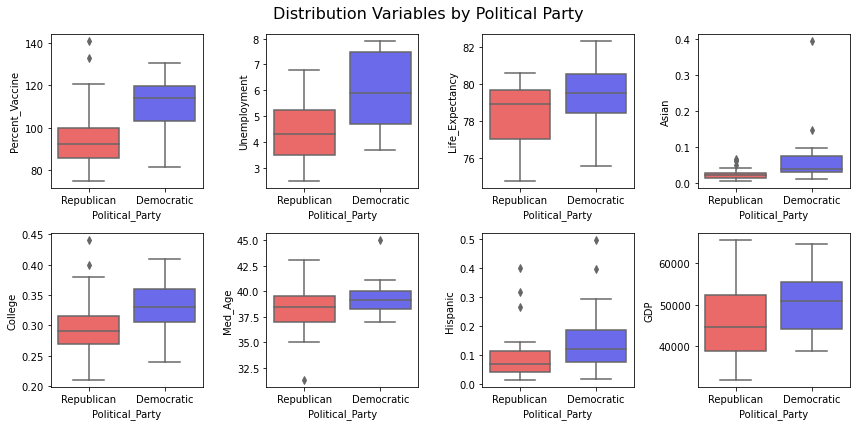

In [206]:
plt.figure(figsize=(12,6))
plt.suptitle('Distribution Variables by Political Party', fontsize=16)
j=1
for i in toplot:
    plt.subplot(2,4,j)
    sns.boxplot(y=i, x='Political_Party', data=States, palette="seismic_r")
    plt.tight_layout()
    j=j+1

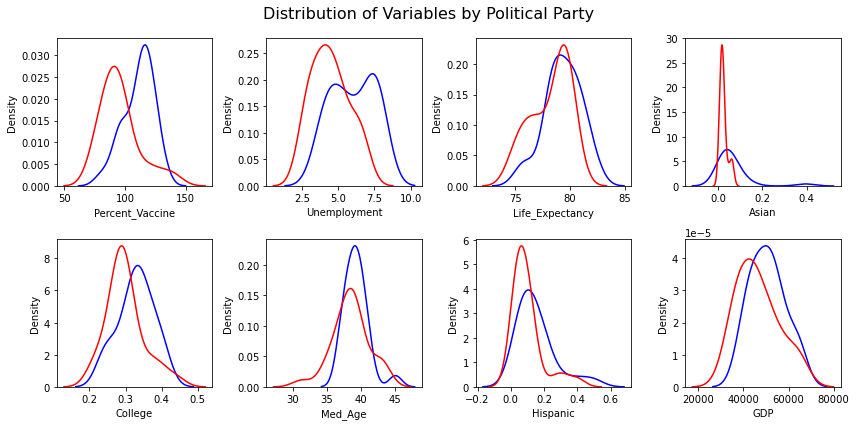

In [207]:
plt.figure(figsize=(12,6))
plt.suptitle('Distribution of Variables by Political Party', fontsize=16)

j=1
for i in toplot:
    plt.subplot(2,4,j)
    sns.distplot(States[States['Political_Party'] != 'Republican'][i], hist=False, color="b")
    sns.distplot(States[States['Political_Party'] != 'Democratic'][i], hist=False, color="r")
    plt.tight_layout()
    j=j+1

## 3.0 EDA: Multi Variate  

In [208]:
States_Sub = States[['Percent_Death','Unemployment', 'GDP', 'High_School', 'College', 'Obesity', 
                     'White', 'Black', 'Hispanic', 'Asian', 'Percent_Vaccine', 'Life_Expectancy',
                     'Political_Party_N', 'Pop_Density', 'Med_Age', 'Election_N']]

States_Cor = pd.DataFrame(States_Sub.corr().Percent_Death.abs().sort_values(ascending=False).reset_index().drop(0,axis=0))
States_Cor.columns = ['Category', 'Correlation']
print('table of correlation values with percentage of death')
States_Cor

table of correlation values with percentage of death


Category  Correlation
1         High_School     0.489298
2         Pop_Density     0.480644
3               Black     0.445699
4        Unemployment     0.287978
5             Obesity     0.280067
6     Life_Expectancy     0.247336
7               Asian     0.231044
8            Hispanic     0.202647
9               White     0.197065
10    Percent_Vaccine     0.170903
11            College     0.147099
12         Election_N     0.070120
13                GDP     0.013277
14  Political_Party_N     0.004680
15            Med_Age     0.002456

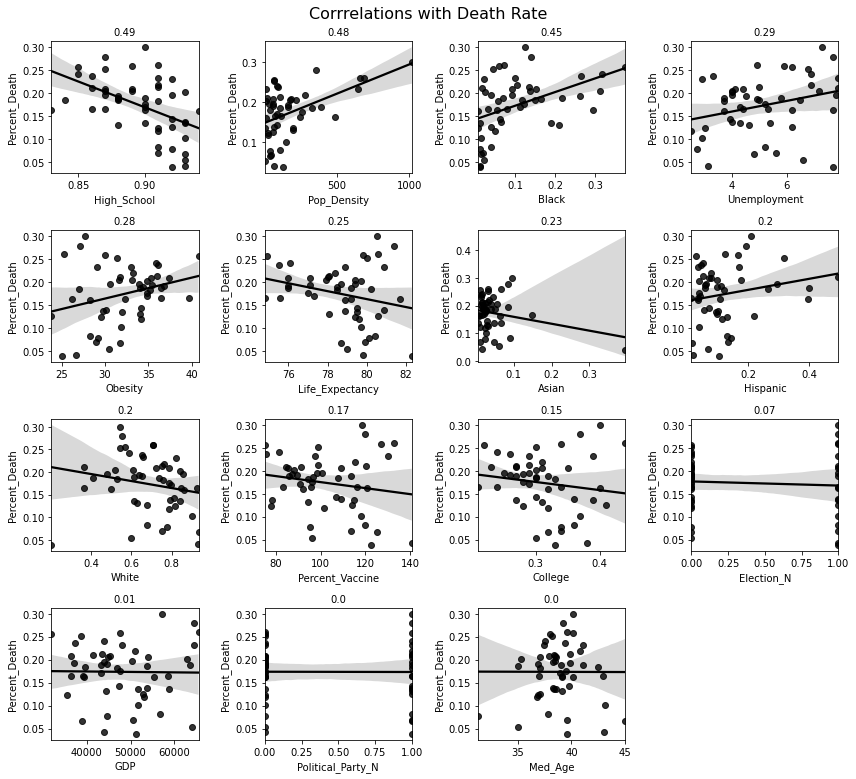

In [209]:
plt.figure(figsize=(12,11))
plt.suptitle('Corrrelations with Death Rate', fontsize=16)

j=1
for i in States_Cor.Category[0:16]:
    plt.subplot(4,4,j)
    plt.title(round(States_Cor.Correlation[j], 2), fontsize=10)
    sns.regplot(x=i, y='Percent_Death', data=States, color="black")
    plt.tight_layout()
    j=j+1

There is an outlier in the Asian column 

In [210]:
States[States['Asian'] > .3]

State  Population Political_Party  Election  Cases  Deaths    Tests  \
10  Hawaii     1415872      Democratic  Democrat  46503     542  1908582   

    Vaccine  Unemployment    GDP  ...  Death_Compare  Percent_Tests  \
10  1731970           7.7  51277  ...              0       2.436521   

    Percent_Vaccine  Percent_Death  Percent_Death_7  Percent_Cases  \
10       122.325323        0.03828         0.001978       3.284407   

    Pop_Density  Political_Party_N  Election_N      temp  
10     129.5196                  1           1  0.001978  

[1 rows x 31 columns]

Remove Hawaii as an outlier for asian population

In [211]:
States.loc[States['Asian'] > .3, 'Asian'] = States.Asian.mean()

<AxesSubplot:xlabel='Asian', ylabel='Percent_Death'>

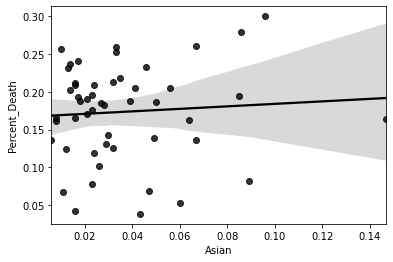

In [212]:
sns.regplot(x='Asian', y='Percent_Death', data=States, color="black")

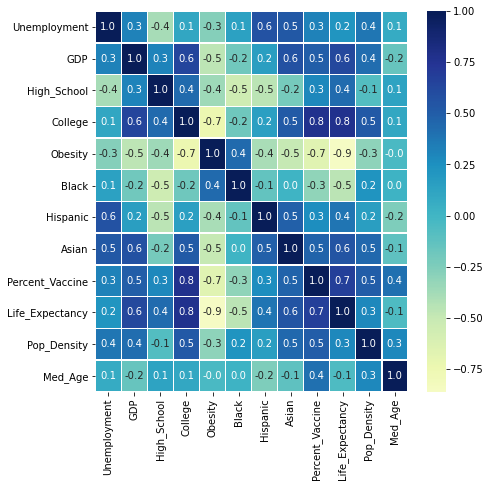

In [213]:
#Correlation plot
temp = States[['Unemployment', 'GDP', 'High_School', 'College', 'Obesity', 'Black', 'Hispanic', 'Asian',
            'Percent_Vaccine', 'Life_Expectancy', 'Pop_Density', 'Med_Age']]
plt.figure(figsize=(7,7))
sns.heatmap(temp.corr(), annot=True, linewidths=.5, fmt= '.1f', center = 0, cmap="YlGnBu" )  # heatmap
plt.show()

<AxesSubplot:xlabel='Obesity', ylabel='Life_Expectancy'>

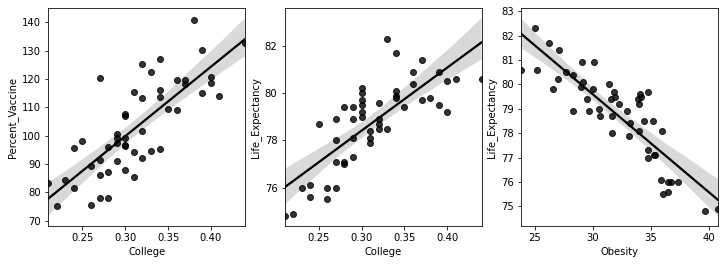

In [214]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.regplot(x='College', y='Percent_Vaccine', data=States, color="black")

plt.subplot(1,3,2)
sns.regplot(x='College', y='Life_Expectancy', data=States, color="black")

plt.subplot(1,3,3)
sns.regplot(x='Obesity', y='Life_Expectancy', data=States, color="black")

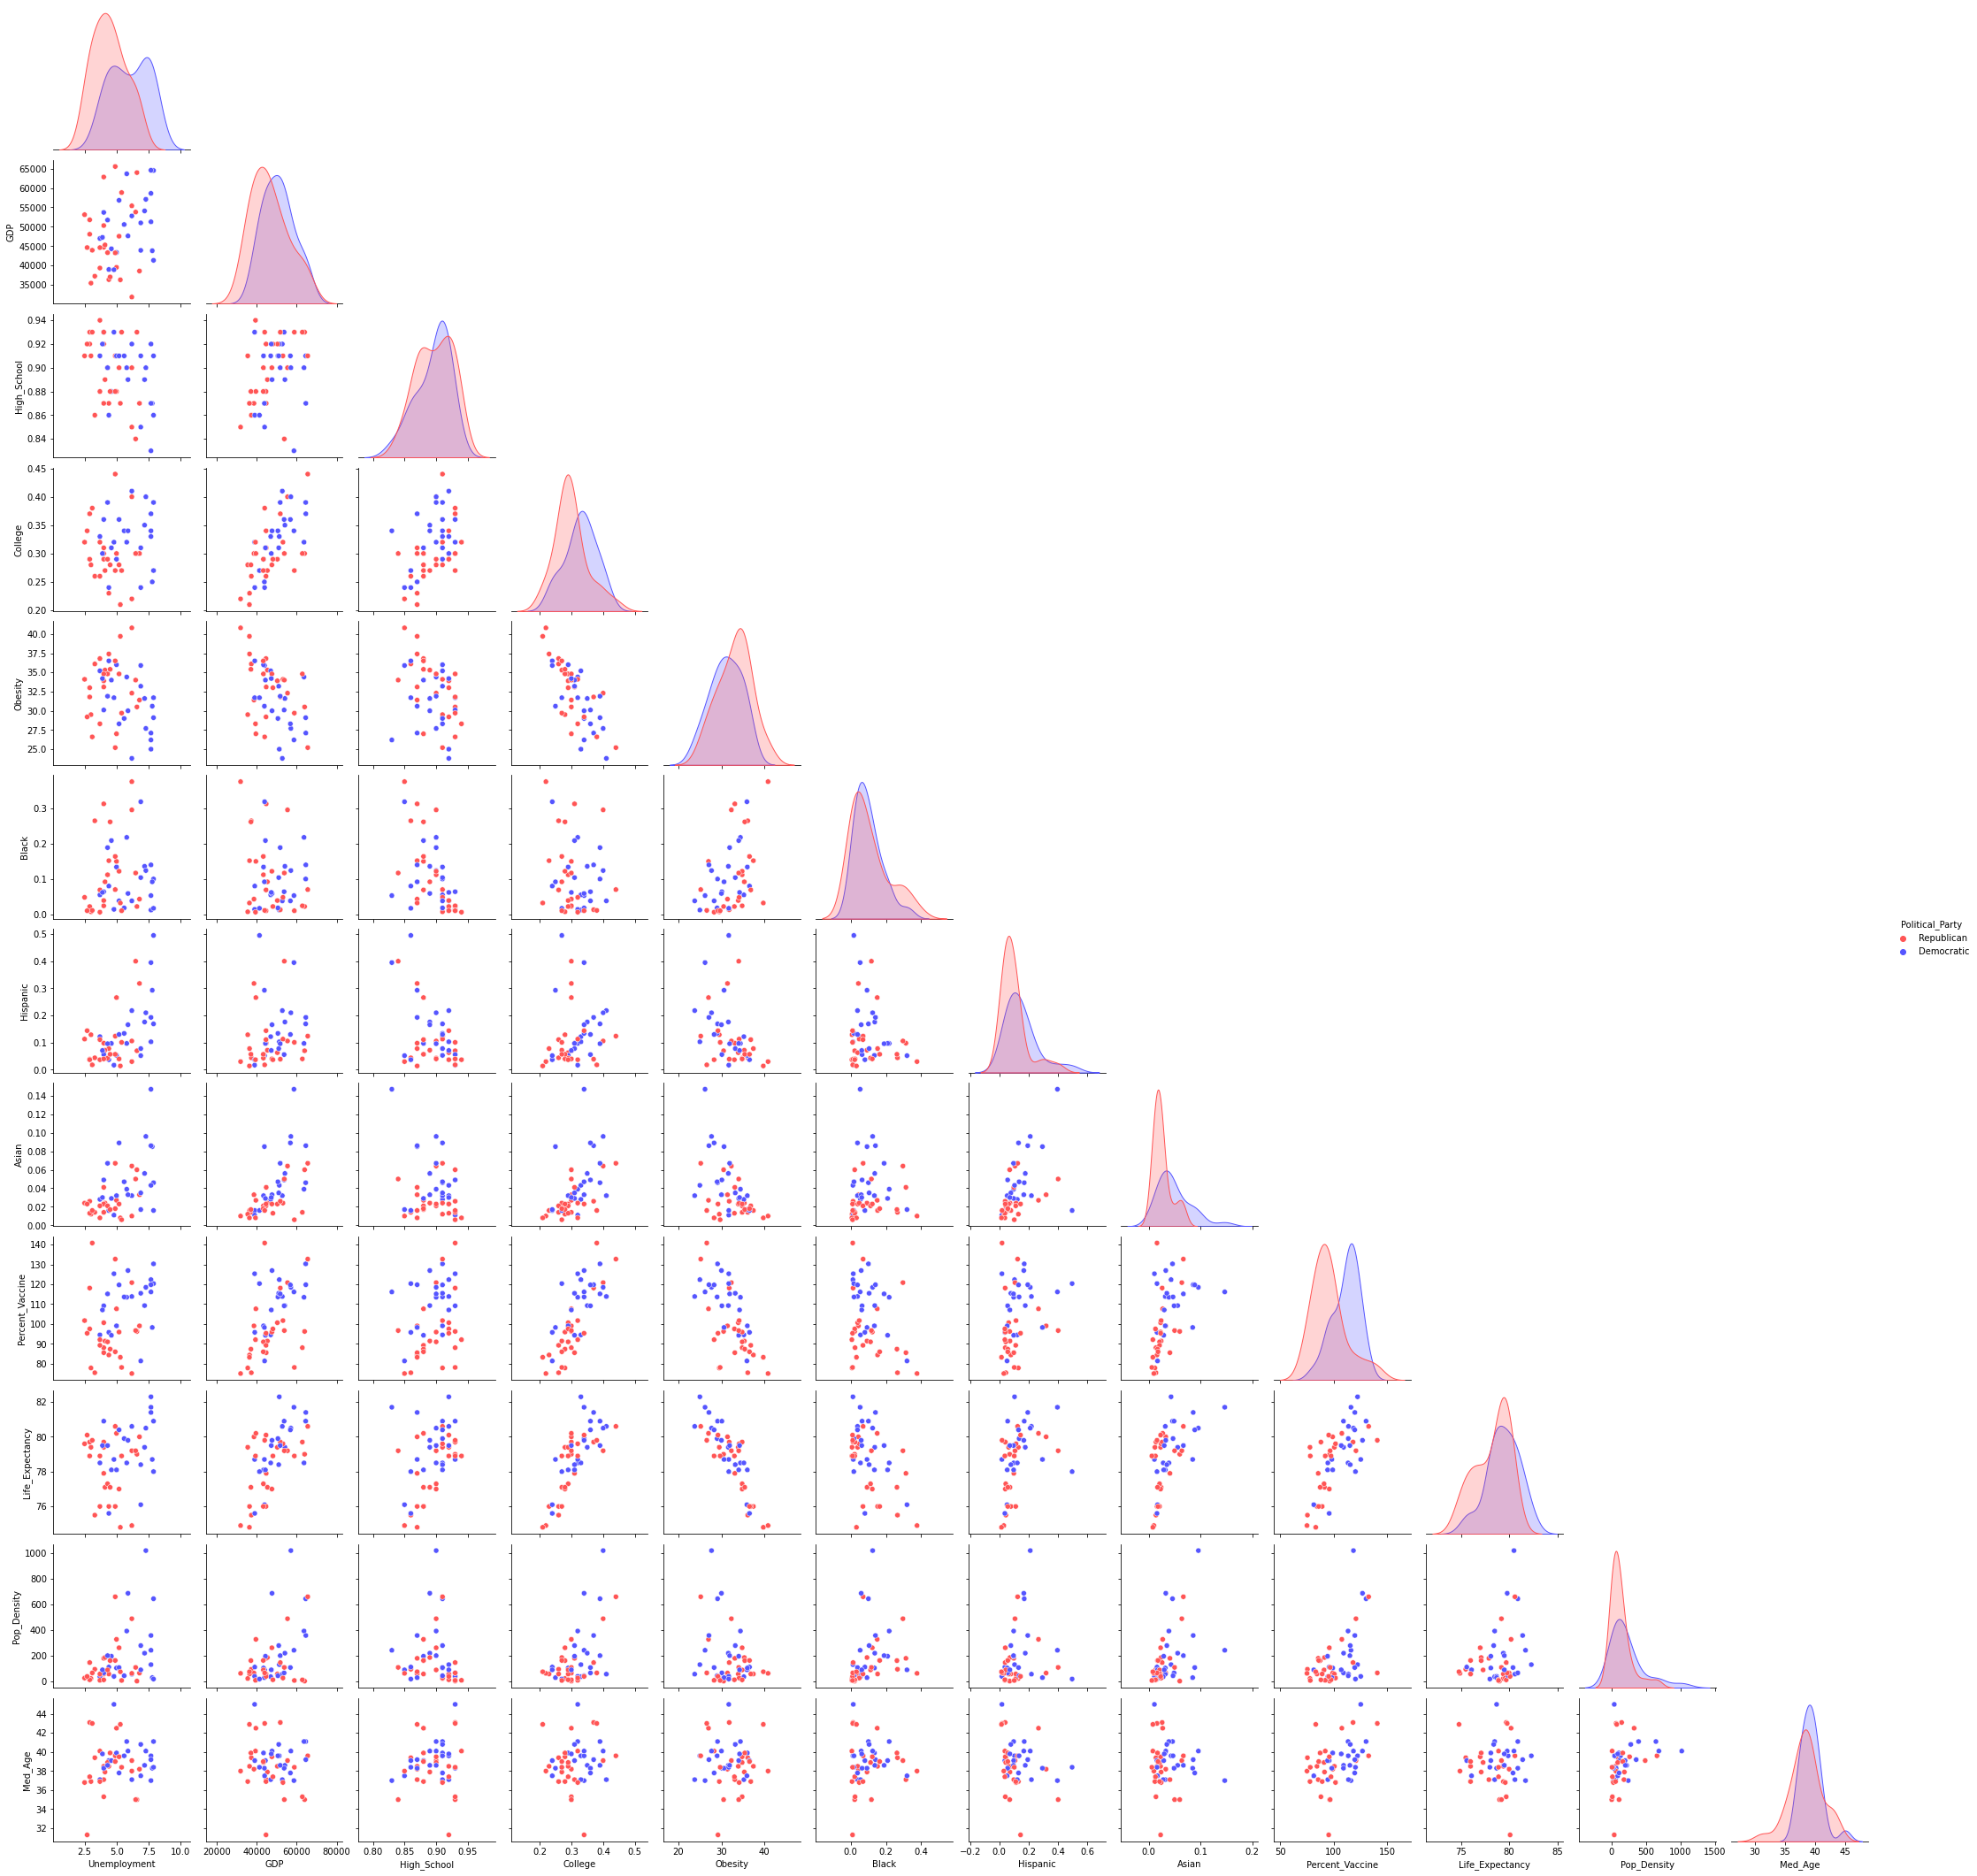

In [215]:
temp['Political_Party'] = States['Political_Party']
sns.pairplot(temp, hue = 'Political_Party', palette="seismic_r", corner=True)

## 4.0 Linear Regression Modeling

### 4.1 Create Dependent (Y) and Independendt (X) variables

Create dependent(y) and independent (x) variables. X is then scaled per column. 

In [216]:
X = States[['Unemployment', 'GDP', 'High_School', 'College', 'Obesity', 'Black', 'Hispanic', 'Asian',
            'Percent_Vaccine', 'Life_Expectancy', 'Political_Party_N', 'Pop_Density', 'Election_N', 'Med_Age']]
Y = States[['Percent_Death']]
X.iloc[:,:] = MinMaxScaler().fit_transform(X) #scale data

Check Multicollinearity using VIF scores

In [217]:
vif_series1 = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns)
pd.DataFrame(vif_series1, columns={'VIF'}).sort_values(['VIF'], ascending=False)

VIF
College            45.304205
Life_Expectancy    43.161759
High_School        39.596605
Percent_Vaccine    25.718074
Med_Age            23.492489
Obesity            15.489973
GDP                15.297951
Unemployment       13.281068
Hispanic            8.142943
Asian               7.681231
Black               6.740213
Election_N          6.084510
Pop_Density         3.780095
Political_Party_N   3.303359

College and Life_Expepectancy have the highest VIF scores and will be removed. Several atributes still have scores that are considered high (above 10), 

In [218]:
X = X.drop(['College', 'Life_Expectancy'], axis=1)

In [219]:
vif_series1 = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns)
pd.DataFrame(vif_series1, columns={'VIF'}).sort_values(['VIF'], ascending=False)

VIF
Med_Age            22.702888
Percent_Vaccine    19.115201
GDP                13.947007
High_School        13.742428
Obesity            10.626273
Unemployment       10.238225
Asian               6.018169
Election_N          5.640821
Hispanic            4.203196
Black               4.172649
Pop_Density         3.381721
Political_Party_N   3.271213

Drop Med_Age

In [220]:
X = X.drop(['Med_Age'], axis=1)

In [221]:
vif_series1 = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns)
pd.DataFrame(vif_series1, columns={'VIF'}).sort_values(['VIF'], ascending=False)

VIF
Percent_Vaccine    14.323056
GDP                11.133157
High_School        10.906314
Unemployment        8.971839
Obesity             7.661214
Asian               6.018102
Election_N          5.632715
Black               4.148238
Hispanic            4.094081
Pop_Density         3.261507
Political_Party_N   3.229111

In [222]:
TEMP = pd.DataFrame() #Data frame to store iterative model outputs
for i in range(1,5001):
    model_N = "Model%d"%i
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
    model = RidgeCV(alphas=[x/10 for x in range(1, 101)])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    temp = pd.DataFrame([[model_N, r2_score(y_test, pred), model.intercept_[0]]],
                        columns=['model', 'R_Score', 'intercept'])
    temp2 = pd.DataFrame(model.coef_, columns = X_train.columns)
    TEMP = TEMP.append(temp.join(temp2))
    
best_model = TEMP.sort_values('R_Score', ascending=False).head(1) 
best_model_score = best_model.R_Score
best_model_int = best_model.intercept
best_model = best_model.drop({'model', 'R_Score', 'intercept'}, axis=1).T
best_model_values = best_model.reset_index()
best_model_values.columns = ['Category', 'Coef']
best_model_values = best_model_values.sort_values('Coef', ascending=False)
print('R2 score for the best model is:', best_model_score)

R2 score for the best model is: 0    0.817182
Name: R_Score, dtype: float64


<AxesSubplot:title={'center':'Coeficient Values for Best Model'}, xlabel='Coef', ylabel='Category'>

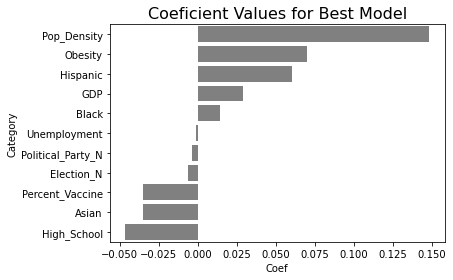

In [223]:
#Plot of the caeficient values for linear regression
plt.title('Coeficient Values for Best Model', fontsize=16)
sns.barplot(x="Coef", y="Category", data=best_model_values, color="grey")

Text(0, 0.5, 'Actual (%)')

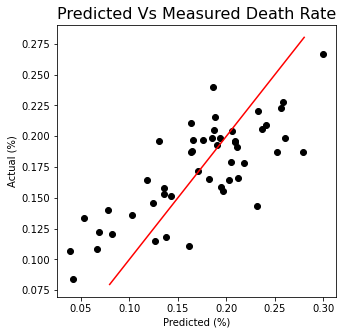

In [224]:
best_model_predict = (X * (best_model.T.append([best_model.T]*49,ignore_index=True))).sum(axis = 1) + ((np.ones(50))*best_model_int[0])
plt.figure(figsize=(5,5))
x = [min(best_model_predict)*.95, max(best_model_predict)*1.05]
y = [min(best_model_predict)*.95, max(best_model_predict)*1.05]
plt.plot(x, y, '-r')
plt.scatter(Y, best_model_predict, color="black")
plt.title('Predicted Vs Measured Death Rate', fontsize=16)
plt.xlabel('Predicted (%)', color='black')
plt.ylabel('Actual (%)', color='black')

Rerun the model with the Y variable of percentage deaths in last 7 days

In [226]:
Y = States[['Percent_Death_7']]

In [227]:
TEMP = pd.DataFrame() #Data frame to store iterative model outputs
for i in range(1,5001):
    model_N = "Model%d"%i
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
    model = RidgeCV(alphas=[x/10 for x in range(1, 101)])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    temp = pd.DataFrame([[model_N, r2_score(y_test, pred), model.intercept_[0]]],
                        columns=['model', 'R_Score', 'intercept'])
    temp2 = pd.DataFrame(model.coef_, columns = X_train.columns)
    TEMP = TEMP.append(temp.join(temp2))
    
best_model = TEMP.sort_values('R_Score', ascending=False).head(1) 
best_model_score = best_model.R_Score
best_model_int = best_model.intercept
best_model = best_model.drop({'model', 'R_Score', 'intercept'}, axis=1).T
best_model_values = best_model.reset_index()
best_model_values.columns = ['Category', 'Coef']
best_model_values = best_model_values.sort_values('Coef', ascending=False)
print('R2 score for the best model is:', best_model_score)

R2 score for the best model is: 0    0.896565
Name: R_Score, dtype: float64


<AxesSubplot:xlabel='Coef', ylabel='Category'>

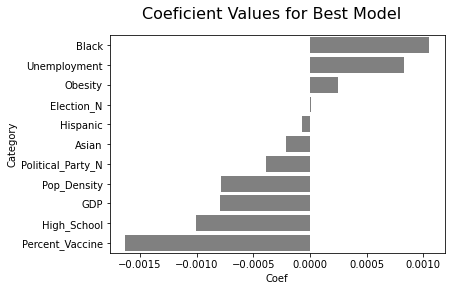

In [228]:
#Plot of the caeficient values for linear regression
plt.suptitle('Coeficient Values for Best Model', fontsize=16)
sns.barplot(x="Coef", y="Category", data=best_model_values, color="grey")

Text(0, 0.5, 'Actual (%)')

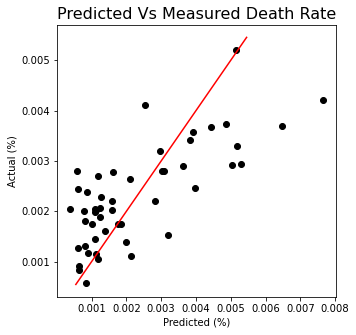

In [229]:
best_model_predict = (X * (best_model.T.append([best_model.T]*49,ignore_index=True))).sum(axis = 1) + ((np.ones(50))*best_model_int[0])
plt.figure(figsize=(5,5))
x = [min(best_model_predict)*.95, max(best_model_predict)*1.05]
y = [min(best_model_predict)*.95, max(best_model_predict)*1.05]
plt.plot(x, y, '-r')
plt.scatter(Y, best_model_predict, color="black")
plt.title('Predicted Vs Measured Death Rate', fontsize=16)
plt.xlabel('Predicted (%)', color='black')
plt.ylabel('Actual (%)', color='black')

### 5 Logistics Regression Model

In [230]:
Y = States[['Death_Compare']]

In [231]:
Y.value_counts()

Death_Compare
0                26
1                24
dtype: int64

A fairly even split of states that are above (1) and below (0) the national average

In [232]:
TEMP = pd.DataFrame()
for i in range(1,5001):
    model = "Model%d"%i
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
    rf_estimator = RandomForestClassifier(random_state=1, n_estimators=10, max_depth=4)
    rf_estimator.fit(X_train,y_train)
    temp = pd.DataFrame(rf_estimator.feature_importances_, columns = [model], index = X_train.columns)
    TEMP[model] = temp[model]
    
TEMP = TEMP.sum(axis=1)/i
TEMP = TEMP.sort_values(ascending = False)
TEMP = TEMP.to_frame()
TEMP = TEMP.reset_index()
TEMP.columns = ['Category', 'Average_Importance']

<AxesSubplot:xlabel='Average_Importance', ylabel='Category'>

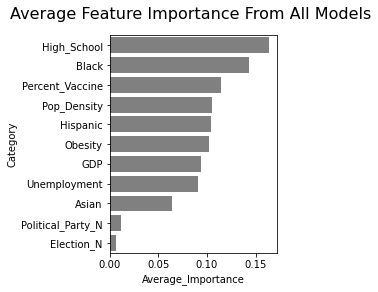

In [233]:
plt.figure(figsize=(3,4))
plt.suptitle('Average Feature Importance From All Models', fontsize=16)
sns.barplot(x="Average_Importance", y="Category", data=TEMP, color="grey")

In [234]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [235]:
States['Abr'] = States['State'].map(us_state_abbrev) 

In [236]:
fig = px.choropleth(States,  # Input Pandas DataFrame
                    locations="Abr",  # DataFrame column with locations
                    color="Percent_Death_7",  # DataFrame column with color values
                    hover_name="State", # DataFrame column hover info
                    color_continuous_scale="Bluered",
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'State Rankings', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen